In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from pylab import rcParams
rcParams['figure.figsize'] = 12,8

In [2]:
import pandas as pd
import os

import itertools 
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

In [3]:
import re

In [4]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import phik

In [5]:
path = "/masters_diploma/raw_data/open-meteo-50.44N30.48E188m.csv"

df = pd.read_csv(path, header=2)

In [6]:
df['time'] = df['time'].apply(lambda x: pd.to_datetime(pd.Timestamp(x).strftime('%Y-%m-%d %H:%M:%S')))
df = df.set_index('time')
df.index.name = 'date'
df

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),precipitation (mm),rain (mm),snowfall (cm),weather_code (wmo code),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),is_day (),sunshine_duration (s)
date,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.5,94.0,0.6,0.6,0.1,0.35,73.0,1009.8,986.5,97.0,23.2,296.0,0,0.0
2020-01-01 01:00:00,1.0,95.0,0.4,0.3,0.3,0.00,51.0,1010.4,987.1,100.0,25.1,302.0,0,0.0
2020-01-01 02:00:00,1.5,93.0,0.5,0.2,0.2,0.00,51.0,1010.8,987.5,100.0,26.6,311.0,0,0.0
2020-01-01 03:00:00,1.5,92.0,0.4,0.1,0.1,0.00,51.0,1011.7,988.4,100.0,26.7,316.0,0,0.0
2020-01-01 04:00:00,1.0,94.0,0.2,0.2,0.2,0.00,51.0,1012.8,989.4,100.0,25.5,316.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2025-01-06 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2025-01-06 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


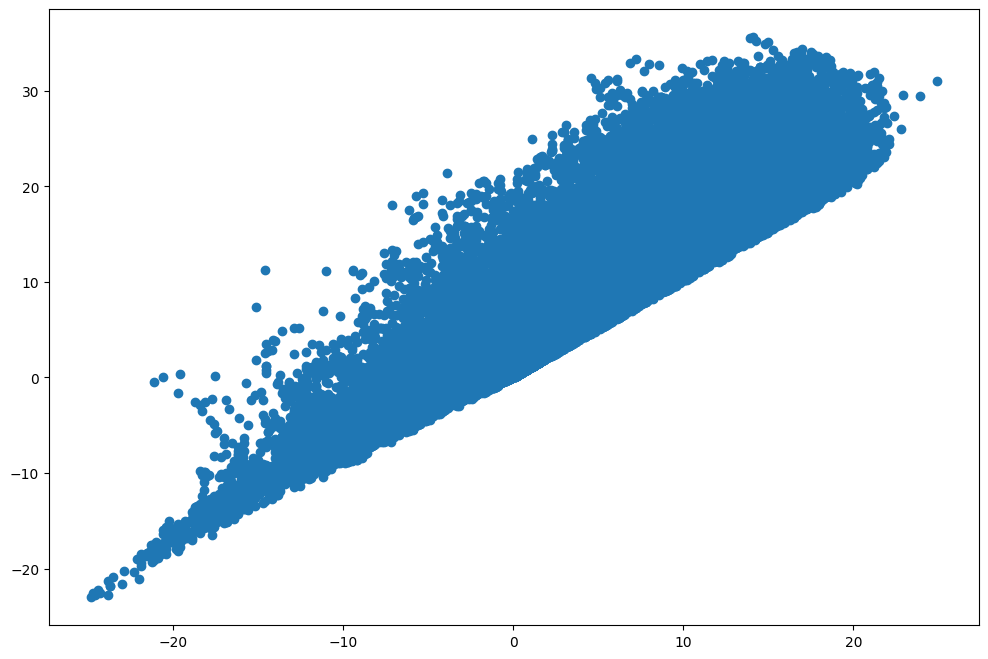

In [7]:
plt.scatter(x='dew_point_2m (°C)', y='temperature_2m (°C)', data=df)

In [8]:
# plt.plot(df['temperature_2m (°C)'])

In [9]:
df.columns = [i.split(" (")[0] for i in df.columns]
df.columns = [re.split(r"_\d+", i)[0] if i.endswith('m') else i for i in df.columns]
df.columns

Index(['temperature', 'relative_humidity', 'dew_point', 'precipitation',
       'rain', 'snowfall', 'weather_code', 'pressure_msl', 'surface_pressure',
       'cloud_cover', 'wind_speed', 'wind_direction', 'is_day',
       'sunshine_duration'],
      dtype='object')

In [10]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['week_day'] = df.index.day_of_week
df['year_day'] = df.index.day_of_year

In [11]:
for feature in ['temperature', 'relative_humidity', 'dew_point', 'precipitation', 'rain', 'snowfall', 'pressure_msl', 
                'surface_pressure', 'cloud_cover', 'wind_speed', 'wind_direction', 'sunshine_duration']:
    for window in [3, 5, 7]:

        close_agg = pd.DataFrame(round(df.groupby('hour')[f'{feature}'].rolling(window=window, closed='left').agg(
            ('max', 'min', 'mean')
        )))
        close_agg.columns = [f'{feature}_max_{window}_days', f'{feature}_min_{window}_days', f'{feature}_mean_{window}_days']
        day_mean = close_agg.reset_index()[['date', f'{feature}_max_{window}_days', f'{feature}_min_{window}_days', f'{feature}_mean_{window}_days']]

        df = df.reset_index().merge(day_mean, on='date').set_index("date")
     
    
    for window in [3, 5, 7]:

        close_agg = pd.DataFrame(round(df.groupby('week_day')[f'{feature}'].rolling(window=window, closed='left').agg(
            ('max', 'min', 'mean')
        )))
        close_agg.columns = [f'{feature}_max_{window}_weeks', f'{feature}_min_{window}_weeks', f'{feature}_mean_{window}_weeks']
        day_mean = close_agg.reset_index()[['date', f'{feature}_max_{window}_weeks', f'{feature}_min_{window}_weeks', f'{feature}_mean_{window}_weeks']]

        df = df.reset_index().merge(day_mean, on='date').set_index("date")
    
    
    for window in [3, 4]:

        close_agg = pd.DataFrame(round(df.groupby('year_day')[f'{feature}'].rolling(window=window, closed='left').agg(
            ('max', 'min', 'mean')
        )))
        close_agg.columns = [f'{feature}_max_{window}_years', f'{feature}_min_{window}_years', f'{feature}_mean_{window}_years']
        day_mean = close_agg.reset_index()[['date', f'{feature}_max_{window}_years', f'{feature}_min_{window}_years', f'{feature}_mean_{window}_years']]

        df = df.reset_index().merge(day_mean, on='date').set_index("date")
        
        
    for h in [24, 48, 72]:
        df[f'{feature}_lag_{h}'] = df[[f'{feature}']].shift(h)

In [12]:
df = df[:df.index.date[-1]].bfill()
df

,temperature,relative_humidity,dew_point,precipitation,rain,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,...,sunshine_duration_mean_7_weeks,sunshine_duration_max_3_years,sunshine_duration_min_3_years,sunshine_duration_mean_3_years,sunshine_duration_max_4_years,sunshine_duration_min_4_years,sunshine_duration_mean_4_years,sunshine_duration_lag_24,sunshine_duration_lag_48,sunshine_duration_lag_72
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.5,94.0,0.6,0.6,0.1,0.35,73.0,1009.8,986.5,97.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,1.0,95.0,0.4,0.3,0.3,0.00,51.0,1010.4,987.1,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,1.5,93.0,0.5,0.2,0.2,0.00,51.0,1010.8,987.5,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,1.5,92.0,0.4,0.1,0.1,0.00,51.0,1011.7,988.4,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,1.0,94.0,0.2,0.2,0.2,0.00,51.0,1012.8,989.4,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-05 20:00:00,-3.4,71.0,-7.9,0.0,0.0,0.00,1.0,1018.7,994.8,28.0,...,575.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-05 21:00:00,-3.4,71.0,-7.9,0.0,0.0,0.00,2.0,1018.6,994.7,59.0,...,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-05 22:00:00,-3.7,73.0,-7.9,0.0,0.0,0.00,2.0,1018.4,994.5,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df.describe()

,temperature,relative_humidity,dew_point,precipitation,rain,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,...,sunshine_duration_mean_7_weeks,sunshine_duration_max_3_years,sunshine_duration_min_3_years,sunshine_duration_mean_3_years,sunshine_duration_max_4_years,sunshine_duration_min_4_years,sunshine_duration_mean_4_years,sunshine_duration_lag_24,sunshine_duration_lag_48,sunshine_duration_lag_72
count,43969.000000,43969.000000,43969.000000,43969.000000,43969.000000,43969.000000,43969.000000,43969.000000,43969.000000,43969.000000,...,43969.000000,43969.000000,43969.00000,43969.000000,43969.000000,43969.000000,43969.000000,43969.000000,43969.000000,43969.000000
mean,9.772681,73.302713,4.587023,0.075021,0.063365,0.008188,10.681321,1016.322134,993.530169,65.583752,...,1096.299802,1393.582410,804.92174,1096.300007,1527.713480,688.267871,1097.385840,1095.770677,1095.414666,1095.375003
std,9.726439,18.117080,7.944441,0.355871,0.341913,0.065050,20.592698,8.648656,8.302979,40.487670,...,1300.683423,1699.493983,1444.62712,1484.553034,1721.773171,1359.675382,1436.190055,1602.664017,1602.528402,1602.533932
min,-23.000000,15.000000,-24.800000,0.000000,0.000000,0.000000,0.000000,983.700000,961.900000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.500000,61.000000,-1.100000,0.000000,0.000000,0.000000,1.000000,1010.800000,988.400000,22.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.100000,77.000000,4.500000,0.000000,0.000000,0.000000,3.000000,1016.000000,993.500000,93.000000,...,473.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.800000,89.000000,11.200000,0.000000,0.000000,0.000000,3.000000,1021.800000,998.800000,100.000000,...,2098.000000,3600.000000,558.00000,2462.000000,3600.000000,0.000000,2447.000000,3600.000000,3600.000000,3600.000000
max,35.600000,100.000000,24.900000,15.000000,15.000000,3.640000,75.000000,1047.600000,1022.800000,100.000000,...,3600.000000,3600.000000,3600.00000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000


In [14]:
windows = [1, 2, 3]
features = {'temperature': 'temp'
            , 'relative_humidity': 'humid'
            , 'precipitation': 'precip'
            , 'surface_pressure': 'pres'
            , 'cloud_cover': 'cloud'
            , 'wind_speed': 'wspeed'
            , 'wind_direction': 'wdir'
            }

for feature, fname in features.items():
    
    df[f'mean_{fname}'] = _[feature]
    df.loc['2024-01-01':, f'mean_{fname}'] = None

    for date in df.loc['2024-01-01':,].index:

        date_range = []

        for year in range(2020, date.year):

            try:
                date_range += [pd.to_datetime(f"{year}-{date.month}-{date.day} {date.hour}:00")]

            except ValueError:
                continue


        date_range = [d for d in date_range if d in df.index]

        if len(date_range) > 0:
            df.loc[date, f'mean_{fname}'] = round(df.loc[date_range, feature].mean(), 2)

            
    for window in windows:

        df[f'new_mean_{fname}_{window * 2 + 1}_days'] = _[feature]
        df.loc['2024-01-01':, f'new_mean_{fname}_{window * 2 + 1}_days'] = None

        for date in df.loc['2024-01-01':,].index:

            date_range = []

            for year in range(2020, date.year):

                try:
                    centre_date = pd.to_datetime(f"{year}-{date.month}-{date.day} {date.hour}:00")
                    date_range += list(pd.date_range(centre_date-timedelta(days=window), 
                                                     centre_date+timedelta(days=window), freq='D'))

                except ValueError:
                    continue


            date_range = [d for d in date_range if d in df.index]

            if len(date_range) > 0:
                df.loc[date, f'new_mean_{fname}_{window * 2 + 1}_days'] = round(df.loc[date_range, feature].mean(), 2)
                

df

,temperature,relative_humidity,dew_point,precipitation,rain,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,...,new_mean_cloud_5_days,new_mean_cloud_7_days,mean_wspeed,new_mean_wspeed_3_days,new_mean_wspeed_5_days,new_mean_wspeed_7_days,mean_wdir,new_mean_wdir_3_days,new_mean_wdir_5_days,new_mean_wdir_7_days
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.5,94.0,0.6,0.6,0.1,0.35,73.0,1009.8,986.5,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,1.0,95.0,0.4,0.3,0.3,0.00,51.0,1010.4,987.1,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,1.5,93.0,0.5,0.2,0.2,0.00,51.0,1010.8,987.5,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,1.5,92.0,0.4,0.1,0.1,0.00,51.0,1011.7,988.4,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,1.0,94.0,0.2,0.2,0.2,0.00,51.0,1012.8,989.4,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-05 20:00:00,-3.4,71.0,-7.9,0.0,0.0,0.00,1.0,1018.7,994.8,28.0,...,88.24,85.71,13.34,12.61,13.67,13.64,209.8,190.80,198.60,198.51
2025-01-05 21:00:00,-3.4,71.0,-7.9,0.0,0.0,0.00,2.0,1018.6,994.7,59.0,...,86.60,82.00,12.02,11.95,13.53,13.55,141.0,164.13,182.76,187.80
2025-01-05 22:00:00,-3.7,73.0,-7.9,0.0,0.0,0.00,2.0,1018.4,994.5,74.0,...,86.52,81.77,12.94,12.31,13.53,13.59,261.8,199.40,204.80,203.57


In [15]:
for feature in features.keys():
    
    corr_table = df.corr()[feature]
    phik_corr_table = df.phik_matrix()[feature]

    new_df = pd.concat([corr_table, phik_corr_table], axis=1)
    new_df.columns = ['linear_corr_close', 'phik_corr_close']

    fig = make_subplots(rows=1, cols=1, 
                        subplot_titles=(f"Correlations with {feature.title()}"))

    fig.add_trace(go.Bar(
        y=new_df['linear_corr_close'],
        x=new_df.index,
        name='Linear Correlation',
        marker_color="red"
    ), row=1, col=1)

    fig.add_trace(go.Bar(
        y=new_df['phik_corr_close'],
        x=new_df.index,
        name='Phik Correlation',
        marker_color="blue"
    ), row=1, col=1)

    fig.update_layout(
        title=f'Correlations with {feature.title()}', 
        xaxis_tickangle=-45,
        width=1300,
        height=1000,
        hovermode="x"
    )

    fig.write_html(f'/masters_diploma/correlation_vizualizations/correlations_{feature}.html')

interval columns not set, guessing: ['temperature', 'relative_humidity', 'dew_point', 'precipitation', 'rain', 'snowfall', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'wind_speed', 'wind_direction', 'is_day', 'sunshine_duration', 'year', 'month', 'day', 'hour', 'week_day', 'year_day', 'temperature_max_3_days', 'temperature_min_3_days', 'temperature_mean_3_days', 'temperature_max_5_days', 'temperature_min_5_days', 'temperature_mean_5_days', 'temperature_max_7_days', 'temperature_min_7_days', 'temperature_mean_7_days', 'temperature_max_3_weeks', 'temperature_min_3_weeks', 'temperature_mean_3_weeks', 'temperature_max_5_weeks', 'temperature_min_5_weeks', 'temperature_mean_5_weeks', 'temperature_max_7_weeks', 'temperature_min_7_weeks', 'temperature_mean_7_weeks', 'temperature_max_3_years', 'temperature_min_3_years', 'temperature_mean_3_years', 'temperature_max_4_years', 'temperature_min_4_years', 'temperature_mean_4_years', 'temperature_lag_24', 'temperature_lag_48', 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable precipitation_min_5_days for analysis 1. Dropping this column
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable precipitation_min_7_days for analysis 1. Dropping this column
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable rain_min_5_days for analysis 1. Dropping this column
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable rain_min_7_days for analysis 1. Dropping this column
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

interval columns not set, guessing: ['temperature', 'relative_humidity', 'dew_point', 'precipitation', 'rain', 'snowfall', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'wind_speed', 'wind_direction', 'is_day', 'sunshine_duration', 'year', 'month', 'day', 'hour', 'week_day', 'year_day', 'temperature_max_3_days', 'temperature_min_3_days', 'temperature_mean_3_days', 'temperature_max_5_days', 'temperature_min_5_days', 'temperature_mean_5_days', 'temperature_max_7_days', 'temperature_min_7_days', 'temperature_mean_7_days', 'temperature_max_3_weeks', 'temperature_min_3_weeks', 'temperature_mean_3_weeks', 'temperature_max_5_weeks', 'temperature_min_5_weeks', 'temperature_mean_5_weeks', 'temperature_max_7_weeks', 'temperature_min_7_weeks', 'temperature_mean_7_weeks', 'temperature_max_3_years', 'temperature_min_3_years', 'temperature_mean_3_years', 'temperature_max_4_years', 'temperature_min_4_years', 'temperature_mean_4_years', 'temperature_lag_24', 'temperature_lag_48', 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable snowfall_min_3_days f

interval columns not set, guessing: ['temperature', 'relative_humidity', 'dew_point', 'precipitation', 'rain', 'snowfall', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'wind_speed', 'wind_direction', 'is_day', 'sunshine_duration', 'year', 'month', 'day', 'hour', 'week_day', 'year_day', 'temperature_max_3_days', 'temperature_min_3_days', 'temperature_mean_3_days', 'temperature_max_5_days', 'temperature_min_5_days', 'temperature_mean_5_days', 'temperature_max_7_days', 'temperature_min_7_days', 'temperature_mean_7_days', 'temperature_max_3_weeks', 'temperature_min_3_weeks', 'temperature_mean_3_weeks', 'temperature_max_5_weeks', 'temperature_min_5_weeks', 'temperature_mean_5_weeks', 'temperature_max_7_weeks', 'temperature_min_7_weeks', 'temperature_mean_7_weeks', 'temperature_max_3_years', 'temperature_min_3_years', 'temperature_mean_3_years', 'temperature_max_4_years', 'temperature_min_4_years', 'temperature_mean_4_years', 'temperature_lag_24', 'temperature_lag_48', 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable snowfall_min_3_days f

interval columns not set, guessing: ['temperature', 'relative_humidity', 'dew_point', 'precipitation', 'rain', 'snowfall', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'wind_speed', 'wind_direction', 'is_day', 'sunshine_duration', 'year', 'month', 'day', 'hour', 'week_day', 'year_day', 'temperature_max_3_days', 'temperature_min_3_days', 'temperature_mean_3_days', 'temperature_max_5_days', 'temperature_min_5_days', 'temperature_mean_5_days', 'temperature_max_7_days', 'temperature_min_7_days', 'temperature_mean_7_days', 'temperature_max_3_weeks', 'temperature_min_3_weeks', 'temperature_mean_3_weeks', 'temperature_max_5_weeks', 'temperature_min_5_weeks', 'temperature_mean_5_weeks', 'temperature_max_7_weeks', 'temperature_min_7_weeks', 'temperature_mean_7_weeks', 'temperature_max_3_years', 'temperature_min_3_years', 'temperature_mean_3_years', 'temperature_max_4_years', 'temperature_min_4_years', 'temperature_mean_4_years', 'temperature_lag_24', 'temperature_lag_48', 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable snowfall_min_3_days f

interval columns not set, guessing: ['temperature', 'relative_humidity', 'dew_point', 'precipitation', 'rain', 'snowfall', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'wind_speed', 'wind_direction', 'is_day', 'sunshine_duration', 'year', 'month', 'day', 'hour', 'week_day', 'year_day', 'temperature_max_3_days', 'temperature_min_3_days', 'temperature_mean_3_days', 'temperature_max_5_days', 'temperature_min_5_days', 'temperature_mean_5_days', 'temperature_max_7_days', 'temperature_min_7_days', 'temperature_mean_7_days', 'temperature_max_3_weeks', 'temperature_min_3_weeks', 'temperature_mean_3_weeks', 'temperature_max_5_weeks', 'temperature_min_5_weeks', 'temperature_mean_5_weeks', 'temperature_max_7_weeks', 'temperature_min_7_weeks', 'temperature_mean_7_weeks', 'temperature_max_3_years', 'temperature_min_3_years', 'temperature_mean_3_years', 'temperature_max_4_years', 'temperature_min_4_years', 'temperature_mean_4_years', 'temperature_lag_24', 'temperature_lag_48', 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable snowfall_min_3_days f

interval columns not set, guessing: ['temperature', 'relative_humidity', 'dew_point', 'precipitation', 'rain', 'snowfall', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'wind_speed', 'wind_direction', 'is_day', 'sunshine_duration', 'year', 'month', 'day', 'hour', 'week_day', 'year_day', 'temperature_max_3_days', 'temperature_min_3_days', 'temperature_mean_3_days', 'temperature_max_5_days', 'temperature_min_5_days', 'temperature_mean_5_days', 'temperature_max_7_days', 'temperature_min_7_days', 'temperature_mean_7_days', 'temperature_max_3_weeks', 'temperature_min_3_weeks', 'temperature_mean_3_weeks', 'temperature_max_5_weeks', 'temperature_min_5_weeks', 'temperature_mean_5_weeks', 'temperature_max_7_weeks', 'temperature_min_7_weeks', 'temperature_mean_7_weeks', 'temperature_max_3_years', 'temperature_min_3_years', 'temperature_mean_3_years', 'temperature_max_4_years', 'temperature_min_4_years', 'temperature_mean_4_years', 'temperature_lag_24', 'temperature_lag_48', 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable snowfall_min_3_days f

interval columns not set, guessing: ['temperature', 'relative_humidity', 'dew_point', 'precipitation', 'rain', 'snowfall', 'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'wind_speed', 'wind_direction', 'is_day', 'sunshine_duration', 'year', 'month', 'day', 'hour', 'week_day', 'year_day', 'temperature_max_3_days', 'temperature_min_3_days', 'temperature_mean_3_days', 'temperature_max_5_days', 'temperature_min_5_days', 'temperature_mean_5_days', 'temperature_max_7_days', 'temperature_min_7_days', 'temperature_mean_7_days', 'temperature_max_3_weeks', 'temperature_min_3_weeks', 'temperature_mean_3_weeks', 'temperature_max_5_weeks', 'temperature_min_5_weeks', 'temperature_mean_5_weeks', 'temperature_max_7_weeks', 'temperature_min_7_weeks', 'temperature_mean_7_weeks', 'temperature_max_3_years', 'temperature_min_3_years', 'temperature_mean_3_years', 'temperature_max_4_years', 'temperature_min_4_years', 'temperature_mean_4_years', 'temperature_lag_24', 'temperature_lag_48', 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable precipitation_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_5_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable rain_min_7_days for analysis 1. Dropping this column

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\phik\data_quality.py:72: UserWarning:

Not enough unique value for variable snowfall_min_3_days f

In [17]:
for feature, fname in features.items():
    
    fig = make_subplots(rows=1, cols=1, 
                    subplot_titles=(f"Means of {feature.title()}"))


    fig.add_trace(go.Scatter(
        y=df.loc['2024-01-01':, feature],
        x=df.loc['2024-01-01':,:].index,
        name=feature,
        marker_color="black"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        y=df.loc['2024-01-01':, f'new_mean_{fname}_3_days'],
        x=df.loc['2024-01-01':,:].index,
        name=f'new_mean_{fname}_3_days',
        marker_color="blue"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        y=df.loc['2024-01-01':, f'new_mean_{fname}_5_days'],
        x=df.loc['2024-01-01':,:].index,
        name=f'new_mean_{fname}_5_days',
        marker_color="green"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        y=df.loc['2024-01-01':, f'new_mean_{fname}_7_days'],
        x=df.loc['2024-01-01':,:].index,
        name=f'new_mean_{fname}_7_days',
        marker_color="magenta"
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        y=df.loc['2024-01-01':, f'mean_{fname}'],
        x=df.loc['2024-01-01':,:].index,
        name=f'mean_{fname}',
        marker_color="red"
    ), row=1, col=1)

    fig.update_layout(
        title=f'Means of {feature.title()}', 
        xaxis_tickangle=-45,
        width=1300,
        height=1000,
        hovermode="x"
    )

    fig.write_html(f'/masters_diploma/correlation_vizualizations/visualization_mean_{fname}.html')

In [18]:
df

,temperature,relative_humidity,dew_point,precipitation,rain,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,...,new_mean_cloud_5_days,new_mean_cloud_7_days,mean_wspeed,new_mean_wspeed_3_days,new_mean_wspeed_5_days,new_mean_wspeed_7_days,mean_wdir,new_mean_wdir_3_days,new_mean_wdir_5_days,new_mean_wdir_7_days
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1.5,94.0,0.6,0.6,0.1,0.35,73.0,1009.8,986.5,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,1.0,95.0,0.4,0.3,0.3,0.00,51.0,1010.4,987.1,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,1.5,93.0,0.5,0.2,0.2,0.00,51.0,1010.8,987.5,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,1.5,92.0,0.4,0.1,0.1,0.00,51.0,1011.7,988.4,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,1.0,94.0,0.2,0.2,0.2,0.00,51.0,1012.8,989.4,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-05 20:00:00,-3.4,71.0,-7.9,0.0,0.0,0.00,1.0,1018.7,994.8,28.0,...,88.24,85.71,13.34,12.61,13.67,13.64,209.8,190.80,198.60,198.51
2025-01-05 21:00:00,-3.4,71.0,-7.9,0.0,0.0,0.00,2.0,1018.6,994.7,59.0,...,86.60,82.00,12.02,11.95,13.53,13.55,141.0,164.13,182.76,187.80
2025-01-05 22:00:00,-3.7,73.0,-7.9,0.0,0.0,0.00,2.0,1018.4,994.5,74.0,...,86.52,81.77,12.94,12.31,13.53,13.59,261.8,199.40,204.80,203.57


In [19]:
list(df.columns)

['temperature',
 'relative_humidity',
 'dew_point',
 'precipitation',
 'rain',
 'snowfall',
 'weather_code',
 'pressure_msl',
 'surface_pressure',
 'cloud_cover',
 'wind_speed',
 'wind_direction',
 'is_day',
 'sunshine_duration',
 'year',
 'month',
 'day',
 'hour',
 'week_day',
 'year_day',
 'temperature_max_3_days',
 'temperature_min_3_days',
 'temperature_mean_3_days',
 'temperature_max_5_days',
 'temperature_min_5_days',
 'temperature_mean_5_days',
 'temperature_max_7_days',
 'temperature_min_7_days',
 'temperature_mean_7_days',
 'temperature_max_3_weeks',
 'temperature_min_3_weeks',
 'temperature_mean_3_weeks',
 'temperature_max_5_weeks',
 'temperature_min_5_weeks',
 'temperature_mean_5_weeks',
 'temperature_max_7_weeks',
 'temperature_min_7_weeks',
 'temperature_mean_7_weeks',
 'temperature_max_3_years',
 'temperature_min_3_years',
 'temperature_mean_3_years',
 'temperature_max_4_years',
 'temperature_min_4_years',
 'temperature_mean_4_years',
 'temperature_lag_24',
 'temperature_

In [20]:
_1 = df.loc['2024-01-01':, ['temperature', 'new_mean_temp_3_days', 'new_mean_temp_5_days', 'new_mean_temp_7_days', 'mean_temp']]

_2 = pd.DataFrame(None, index=_1.index)
for col in _1.columns[1:]:
    _2.loc[:, col] = abs(_1.loc[:, col] - _1.loc[:, 'temperature'])
    
_3 = pd.DataFrame(index=_2.index, columns=_2.columns)
for row in _2.index:
    min_col = _2.loc[row, :].idxmin()  # Get the column with the minimum value
    for col in _3.columns:
        _3.loc[row, col] = 1 if col == min_col else 0  # Assign 1 if it's the min column, otherwise 0

_3

,new_mean_temp_3_days,new_mean_temp_5_days,new_mean_temp_7_days,mean_temp
date,,,,
2024-01-01 00:00:00,0,0,1,0
2024-01-01 01:00:00,0,0,1,0
2024-01-01 02:00:00,0,0,1,0
2024-01-01 03:00:00,0,0,1,0
2024-01-01 04:00:00,0,0,1,0
...,...,...,...,...
2025-01-05 20:00:00,0,0,1,0
2025-01-05 21:00:00,0,0,1,0
2025-01-05 22:00:00,0,0,1,0


In [21]:
_3.sum()

new_mean_temp_3_days    1614
new_mean_temp_5_days    1338
new_mean_temp_7_days    3122
mean_temp               2831
dtype: object

In [22]:
df.to_csv('/masters_diploma/processed_data/history_weather.csv')